# Introduction 
 To find open bookings on resturants I would like to go to

Below i will import the necessary libraries

In [28]:
import utilities as my 
import pandas as pd 
import regex as re 
#import os 
from datetime import datetime, timedelta
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import requests 
import numpy as np 
from time import sleep
%autosave 60 

Autosaving every 60 seconds


# Background
Why is this relevant? <Br/>
What kind of data is needed or foundational processes are needed to make this

In [29]:
resturant_dict = {    
    "Høst":53,
    "Jah Izakaya & Sake Bar":492,
    "Les Trois Cochons":2,
    "Llama":201,
    "Oysters & Grill":8,
    "Restaurant Cofoco":1,
    "Scarpetta - Islands Brygge":6,
    "Scarpetta - Rantzausgade":5,
    "Spuntino":4,
    "Vespa":3,
    "Vækst":279,
    "Delphine":1089,
    "Corsa Nordhavn":1094,
    "Corsa Pizza Islands Brygge":1009,
    "Corsa Vesterbro":1201,
    "Corsa Østerbro":1005,
    "Bullion": 1366
}

def get_booking_times(input_date, resturant_id,  booking_times, guests = 2):
    # Define the base URL and parameters for 'ajax_times'
    base_url = 'https://bordibyen.dk/widget/ajax_times/'
    params = {
        'date': input_date,
        'guests': str(guests),
        'res_id': resturant_id,
        'booking_type_id': '0',
        'booking_length_id': '0',
        'lang': 'danish'
    }

    # Construct the full URL for 'ajax_times'
    full_url = f"{base_url}{params['res_id']}/{params['date']}/{params['guests']}/{params['booking_type_id']}/{params['booking_length_id']}?lang={params['lang']}"

    # Perform the GET request
    response = requests.get(full_url)

    # Print the server's response
    # lets convert the response to a a string
    data = response.text

    import re

    # data = data.replace('<p><label>Vælg tidspunkt</label></p>', '')

    # lets make a regex call which removes any double spaces
    data = re.sub(' +', ' ', data)
    # lets do that for tabs too
    data = re.sub('\t+', '', data)
    # now lets remove empty lines
    data = re.sub('\n+', '\n', data)
    # now lets make a list where we can store the available booking times
    data = data.splitlines()

    for line in data:
        if 'data-guest_end_time' in line:
            # now lets make sure that we get the text 4 characters after the string we  just confirmed was in the line
            number = re.findall(pattern='data-guest_end_time=.{3}(.+)', string=line)
            number = number[0].strip()
            number = input_date + '///' + number
            booking_times.append(number)
            
    return booking_times

# lets create a function that will take a resturant name and return the resturant id
def get_resturant_id(resturant_name):
    return resturant_dict[resturant_name]

# lets make a function which takes a set of unique times and then orders them in a chronological order from lowest to highest time
def order_times(unique_times):
    # now lets make sure that we convert the times to a string
    unique_times = [str(time) for time in unique_times]
    # now lets make sure that we remove the ':' from the times
    unique_times = [time.replace(':', '') for time in unique_times]
    # now lets make sure that we convert the times to integers
    unique_times = [int(time) for time in unique_times]
    # now lets sort the times
    unique_times = sorted(unique_times)
    # now lets convert the times back to strings
    unique_times = [str(time) for time in unique_times]
    # now lets make sure that we add the ':' back to the times
    unique_times = [time[:2] + ':' + time[2:] for time in unique_times]
    # now lets return the unique times
    return unique_times

def make_pivot_table(booking_times) -> pd.DataFrame:
    # now lets take the list of booking times and make a dataframe out of it
    df = pd.DataFrame(booking_times, columns=['date_n_time'])
    # now lets split the column into two columns
    df[['date', 'time']] = df.date_n_time.str.split('///', expand=True)
    # now lets get a list of the unique times
    unique_times = df.time.unique()

    # now lets order the times
    unique_times = order_times(unique_times)
    # now lets make a pivot table
    pivot_df = df.pivot_table(index='date', columns='time', aggfunc='size')
    # now lets fill the NaN values with 0
    pivot_df = pivot_df.fillna(0)
    # now lets reset the index and name the former index column 'date'
    pivot_df = pivot_df.reset_index().rename(columns={'index':'date'})
    # now lets ensure that the second column contains  the weekday of the date
    pivot_df['weekday'] = pd.to_datetime(pivot_df.date).dt.day_name()
    # now lets rearrange the columns, so that date is the first column and weekday is the second column, and all the times are the remaining columns
    pivot_df = pivot_df[['date', 'weekday'] + list(unique_times)]
    # now lets sort the dataframe by date
    pivot_df = pivot_df.sort_values(by='date')
    # now lets reset the index
    pivot_df = pivot_df.reset_index(drop=True)
    # now lets return the pivot table
    return pivot_df

# now lets create a function which gets the date range from now and two weeks forward
def get_two_week_dates(input_date = None):
    # now lets get the current date in a date only format
    if input_date is None:
        current_date = datetime.now().date()
    else:
        current_date = datetime.strptime(input_date, '%Y-%m-%d').date()
    # now lets get the date two weeks from now
    two_weeks_from_now = current_date + timedelta(days=14)
    # now lets create a list of dates between the two dates
    date_range = pd.date_range(current_date, two_weeks_from_now, freq='D')
    # now lets convert the date range to a list
    date_range = date_range.tolist()
    # now lets convert the dates to a string
    date_range = [str(date).split(' ')[0] for date in date_range]
    # now lets return the date range
    print('Here is the date range: ',  current_date, ' to ', two_weeks_from_now)
    return date_range

def get_three_month_dates(input_date = None):
    # now lets get the current date in a date only format
    if input_date is None:
        current_date = datetime.now().date()
    else:
        current_date = datetime.strptime(input_date, '%Y-%m-%d').date()
    # now lets get the date three months from now
    two_weeks_from_now = current_date + timedelta(days=90)
    # now lets create a list of dates between the two dates
    date_range = pd.date_range(current_date, two_weeks_from_now, freq='D')
    # now lets convert the date range to a list
    date_range = date_range.tolist()
    # now lets convert the dates to a string
    date_range = [str(date).split(' ')[0] for date in date_range]
    # now lets return the date range
    print('Here is the date range: ',  current_date, ' to ', two_weeks_from_now)
    return date_range

def get_resturant_name(resturant_id):
    for key, value in resturant_dict.items():
        if value == resturant_id:
            return key

def get_one_day_bookings(relevant_date, resturant_dict, guests = 2):
    try:
    # Now let's make a list of the restaurant names and IDs
        restaurant_names = list(resturant_dict.keys())
        restaurant_ids = list(resturant_dict.values())

        # Initialize the list for booking times
        booking_times = []

        # Iterate through restaurant IDs and names, updating tqdm with the current restaurant name
        with tqdm(total=len(restaurant_ids), desc="Checking the restaurant: ") as pbar:
            for restaurant_id, restaurant_name in zip(restaurant_ids, restaurant_names):
                booking_times = get_booking_times(relevant_date, restaurant_id, booking_times, guests=guests)

                # Update booking times with restaurant name where needed
                tmp = []
                for booking in booking_times:
                    if '-' in booking:
                        booking = restaurant_name + '///' + booking.split('///')[1]
                    tmp.append(booking)
                booking_times = tmp
                pbar.update(1)
                pbar.set_description(f"Checking the restaurant: {restaurant_name}")
           
        # now lets make a pivot table of the booking times from scratch
        pivot_df = pd.DataFrame(booking_times, columns=['date_n_time'])
        # now lets split the column into two columns, one for place and one for time
        pivot_df[['place', 'time']] = pivot_df.date_n_time.str.split('///', expand=True)
        # now lets make sure that the time column is a datetime object
        pivot_df = pivot_df[(pivot_df.time.str.contains('17')) | (pivot_df.time.str.contains('18')) | (pivot_df.time.str.contains('19')) | (pivot_df.time.str.contains('20')) | (pivot_df.time.str.contains('21')) | (pivot_df.time.str.contains('22'))] 
        # now lets get a list of the unique times
        unique_times = pivot_df.time.unique()
        # now lets order the times
        unique_times = order_times(unique_times)
        # now lets make a pivot table
        pivot_df = pivot_df.pivot_table(index='place', columns='time', aggfunc='size')
        # now lets fill the NaN values with 0
        pivot_df = pivot_df.fillna(0)
        # now lets make sure that we sort the rows by the total number of bookings
        pivot_df = pivot_df.sort_values(by=pivot_df.columns.tolist(), ascending=False)
        # now lets reset the index and name the former index column 'date'
        pivot_df = pivot_df.reset_index().rename(columns={'index':'place'})
        # now lets count the amount of bookings for each resturant in a sum colunm, and place it in the second column
        pivot_df['sum'] = pivot_df.iloc[:, 1:].sum(axis=1)
        # now lets sort the dataframe by sum
        pivot_df = pivot_df.sort_values(by='sum', ascending=False)
        # now lets reset the index
        pivot_df = pivot_df.reset_index(drop=True)
        # now lets make sure that the second column contains  the weekday of the date
        pivot_df = pivot_df[['place', 'sum'] + list(unique_times)]
        # now lets give back the code for the booking times
        return pivot_df
    except Exception as e:
        print(e)
        return pivot_df
# lets write a function which gets the next friday based on the current date
def get_next_friday(input_date = None):
    if input_date is None:
        current_date = datetime.now().date()
    else:
        current_date = datetime.strptime(input_date, '%Y-%m-%d').date()
        
    # now lets get the weekday of the current date
    weekday = current_date.weekday()
    # now lets get the date of the next friday
    if weekday == 4:
        current_date = current_date + timedelta(days=7)
    else:
        while weekday != 4:
            current_date = current_date + timedelta(days=1)
            weekday = current_date.weekday()
            
    return current_date.strftime('%Y-%m-%d')

def get_next_saturday(input_date = None):
    if input_date is None:
        current_date = datetime.now().date()
    else:
        current_date = datetime.strptime(input_date, '%Y-%m-%d').date()
        
    # now lets get the weekday of the current date
    weekday = current_date.weekday()
    # now lets get the date of the next friday
    if weekday == 4:
        current_date = current_date + timedelta(days=7)
    else:
        while weekday != 5:
            current_date = current_date + timedelta(days=1)
            weekday = current_date.weekday()
            
    return current_date.strftime('%Y-%m-%d')

def get_today():
    return datetime.now().date().strftime('%Y-%m-%d')

def get_todays_bookings():
    # now lets write a short script which iterates through the resturant_dict and gets the booking times for each resturant for a given date
    relevant_date = get_today()
    bookings = get_one_day_bookings(relevant_date, resturant_dict)
    return bookings

def get_friday_bookings(relevant_date = None):
    # now lets write a short script which iterates through the resturant_dict and gets the booking times for each resturant for a given date
    if relevant_date is None:
        relevant_date = get_next_friday()
    else:
        relevant_date = get_next_friday(relevant_date)
        
    print('The relevant date is: ', relevant_date)
    bookings = get_one_day_bookings(relevant_date, resturant_dict)
    return bookings

def get_saturday_bookings(relevant_date = None):
    # now lets write a short script which iterates through the resturant_dict and gets the booking times for each resturant for a given date
    if relevant_date is None:
        relevant_date = get_next_saturday()
    else:
        relevant_date = get_next_saturday(relevant_date)
        
    print('The relevant date is: ', relevant_date)
    bookings = get_one_day_bookings(relevant_date, resturant_dict)
    return bookings
    
# now lets write a function which takes a list of dates and converts them to a list of datetime objects
def convert_dates_to_datetime(dates):
    # now lets make sure that we convert the dates to datetime objects
    dates = [datetime.strptime(date, '%d-%m-%Y') for date in dates]
    # now lets make sure that we save them in a year-month-day format
    dates = [date.strftime('%Y-%m-%d') for date in dates]
    # now lets return the dates
    return dates

In [30]:
# Her skal vi sætte antallet af kolonner vi vil se, fordi vi gemmer det tidspunkterne som kolonner, så kan der blive mange kolonner
pd.set_option('display.max_columns', 30)  # Replace 10 with your desired number

# Use Case 1
Antag at du har et sæt af dage du gerne vil ud og spise på.

In [31]:
from time import strftime


dates = pd.date_range('2024-08-12', '2024-08-30', freq='D').strftime('%d-%m-%Y').tolist()

dates

['12-08-2024',
 '13-08-2024',
 '14-08-2024',
 '15-08-2024',
 '16-08-2024',
 '17-08-2024',
 '18-08-2024',
 '19-08-2024',
 '20-08-2024',
 '21-08-2024',
 '22-08-2024',
 '23-08-2024',
 '24-08-2024',
 '25-08-2024',
 '26-08-2024',
 '27-08-2024',
 '28-08-2024',
 '29-08-2024',
 '30-08-2024']

In [34]:
# Her skriver du dine datoer i dd-mm-yyyy format
strings = ["03-01-2024",
"07-01-2024",
"14-01-2024",
"16-01-2024",
"17-01-2024",
"23-01-2024",
"24-01-2024"]
strings = dates 
# strings = ['14-08-2024'] 
# Now lets make a date range in the format dd-mm-yyyy from the 12 th of August 24 to the 30th of august 24
# Ford systemet læser det i yyyy-mm-dd format, skal vi lige konvertere det
strings = convert_dates_to_datetime(strings)
# Nu skal vi lave de kolonner som dataen skal lægges ind i
new_columns = ['date', 'place', 'sum', '17:00', '17:15', '17:30', '17:45', '18:00',
                '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00',
                '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45']
# Her laver vi en tom dataframe med de kolonner vi lige har lavet, sådan at vi kan gemme alt dataen i den
df = pd.DataFrame(columns=new_columns)
# Vi løber igennem alle datoerne og henter dataen for hver dag
for date in strings:
    try:
        data = get_one_day_bookings(date, resturant_dict)
        data['date'] = date
        data = data[new_columns]
        
        df = pd.concat([df, data])  
    except Exception as e:
        print(e)
        pass    
# Her er alle de ledige borde på de forskellige datoer
df

Checking the restaurant: Bullion: 100%|██████████| 17/17 [00:22<00:00,  1.31s/it]                   
C:\Users\jbay\AppData\Local\Temp\ipykernel_2804\2057171040.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, data])
Checking the restaurant: Bullion: 100%|██████████| 17/17 [00:21<00:00,  1.26s/it]                   


,date,place,sum,17:00,17:15,17:30,17:45,18:00,18:15,18:30,18:45,19:00,19:15,19:30,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45
0,2024-08-12,Spuntino,43.0,0.0,0.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0
1,2024-08-12,Corsa Nordhavn,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2024-08-12,Corsa Østerbro,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,2024-08-12,Corsa Pizza Islands Brygge,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,2024-08-12,Corsa Vesterbro,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,2024-08-30,Jah Izakaya & Sake Bar,13.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11,2024-08-30,Vespa,11.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
12,2024-08-30,Vækst,11.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
13,2024-08-30,Høst,9.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [33]:
df = aggregate_time_slots(df)

df

,date,place,sum,17:00,18:00,19:00,20:00,21:00
0,2024-08-14,Spuntino,43.0,2.0,12.0,12.0,12.0,5.0
1,2024-08-14,Corsa Nordhavn,17.0,4.0,4.0,4.0,4.0,1.0
2,2024-08-14,Corsa Østerbro,17.0,4.0,4.0,4.0,4.0,1.0
3,2024-08-14,Corsa Pizza Islands Brygge,16.0,4.0,4.0,4.0,4.0,0.0
4,2024-08-14,Corsa Vesterbro,16.0,4.0,4.0,4.0,4.0,0.0
5,2024-08-14,Les Trois Cochons,16.0,2.0,4.0,4.0,4.0,2.0
6,2024-08-14,Oysters & Grill,15.0,2.0,4.0,4.0,4.0,1.0
7,2024-08-14,Jah Izakaya & Sake Bar,14.0,2.0,3.0,1.0,4.0,4.0
8,2024-08-14,Llama,14.0,0.0,4.0,4.0,4.0,2.0
9,2024-08-14,Restaurant Cofoco,14.0,0.0,4.0,4.0,4.0,2.0


In [15]:
df.to_clipboard()

# Use Case 2
Lad os nu tjekke om der nogle borde ledige i dag?

In [4]:
df = get_todays_bookings()

df

Checking the restaurant:   0%|          | 0/17 [00:00<?, ?it/s]

Checking the restaurant: Bullion: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]                   


time,place,sum,17:00,17:15,17:30,17:45,18:00,18:15,18:30,18:45,19:00,19:15,19:30,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45
0,Spuntino,44.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0
1,Corsa Nordhavn,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,Corsa Østerbro,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,Corsa Pizza Islands Brygge,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,Corsa Vesterbro,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
5,Delphine,16.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
6,Les Trois Cochons,16.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
7,Oysters & Grill,15.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
8,Llama,14.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
9,Restaurant Cofoco,14.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


# Use Case 3
Hvad hvis du nu gerne vil ud og spise på fredag?

In [17]:
# Hvis du lader funktionen kører uden at give den en dato, så tager den automatisk den næste lørdag
# Hvis du giver den en dato i formattet yyyy-mm-dd, så tager den den næste lørdag efter den dato
df = get_friday_bookings()

df

Checking the restaurant: Bullion: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]                   


time,place,sum,17:00,17:15,17:30,17:45,18:00,18:15,18:30,18:45,19:00,19:15,19:30,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45
0,Spuntino,40.0,0.0,0.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
1,Corsa Nordhavn,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,Corsa Østerbro,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,Corsa Pizza Islands Brygge,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,Corsa Vesterbro,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
5,Les Trois Cochons,15.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,Restaurant Cofoco,14.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,Llama,13.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,Oysters & Grill,13.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9,Vækst,12.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [20]:
get_friday_bookings('2024-01-04')

Checking the restaurant: Bullion: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]                   


time,place,sum,17:00,17:15,17:30,17:45,18:00,18:15,18:30,18:45,19:00,19:15,19:30,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45
0,Spuntino,40.0,0.0,0.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
1,Corsa Nordhavn,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,Corsa Østerbro,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,Corsa Pizza Islands Brygge,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,Corsa Vesterbro,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
5,Les Trois Cochons,15.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,Restaurant Cofoco,14.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,Llama,13.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,Oysters & Grill,13.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9,Vækst,12.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


# Use Case 4
Hvad hvis du nu gerne vil ud og spise på lørdag?

In [9]:
# Hvis du lader funktionen kører uden at give den en dato, så tager den automatisk den næste lørdag
df = get_saturday_bookings()

df

Checking the restaurant: Bullion: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]                   


time,place,sum,17:00,17:15,17:30,17:45,18:00,18:15,18:30,18:45,...,19:30,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45
0,Spuntino,40.0,0.0,0.0,3.0,3.0,2.0,3.0,3.0,0.0,...,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
1,Corsa Nordhavn,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,Corsa Østerbro,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,Corsa Pizza Islands Brygge,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,Corsa Vesterbro,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
5,Les Trois Cochons,15.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,Llama,14.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,Restaurant Cofoco,14.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,Oysters & Grill,12.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9,Delphine,11.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


# Use Case 5
Nu v il jeg rigtig gerne ud og spise næste lørdag :D 

In [16]:
today = get_today()
# now lets read it to a datetime object
today = datetime.strptime(today, '%Y-%m-%d').date()
# now lets add 6 days to the date
today = today + timedelta(days=6)
# now lets read it back to a string
today = today.strftime('%Y-%m-%d')
# now lets get the next saturday
next_saturday = get_next_saturday(today)
# now lets get the bookings 
df = get_one_day_bookings(next_saturday, resturant_dict)
# now lets print the bookings
df


Checking the restaurant: Bullion: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]                   


time,place,sum,17:00,17:15,17:30,17:45,18:00,18:15,18:30,18:45,19:00,19:15,19:30,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45
0,Spuntino,42.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
1,Corsa Nordhavn,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,Corsa Østerbro,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,Corsa Pizza Islands Brygge,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,Les Trois Cochons,15.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,Corsa Vesterbro,14.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
6,Llama,14.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,Restaurant Cofoco,14.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,Oysters & Grill,13.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9,Delphine,12.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data from clipboard
df = pd.read_clipboard()

# Define a function to aggregate time slots into hourly intervals
def aggregate_time_slots(df):
    time_slots = ['17:00', '18:00', '19:00', '20:00', '21:00']
    for slot in time_slots:
        quarter_hours = [f'{slot[:2]}:{int(slot[3:]) + i*15:02d}' for i in range(4)]
        df[slot] = df[quarter_hours].sum(axis=1)
        df.drop(columns=quarter_hours[1:], inplace=True)
    return df

# Apply the aggregation function
df = aggregate_time_slots(df)

df = df[df.date != '13/08/2024']

df

,date,place,sum,17:00,18:00,19:00,20:00,21:00,Available
15,14/08/2024,Spuntino,43,2,12,12,12,5,True
16,14/08/2024,Corsa Nordhavn,17,4,4,4,4,1,True
17,14/08/2024,Corsa Østerbro,17,4,4,4,4,1,True
18,14/08/2024,Corsa Pizza Islands Brygge,16,4,4,4,4,0,True
19,14/08/2024,Corsa Vesterbro,16,4,4,4,4,0,True
20,14/08/2024,Les Trois Cochons,16,2,4,4,4,2,True
21,14/08/2024,Oysters & Grill,15,2,4,4,4,1,True
22,14/08/2024,Jah Izakaya & Sake Bar,14,2,3,1,4,4,True
23,14/08/2024,Llama,14,0,4,4,4,2,True
24,14/08/2024,Restaurant Cofoco,14,0,4,4,4,2,True


TypeError: Image data of dtype object cannot be converted to float

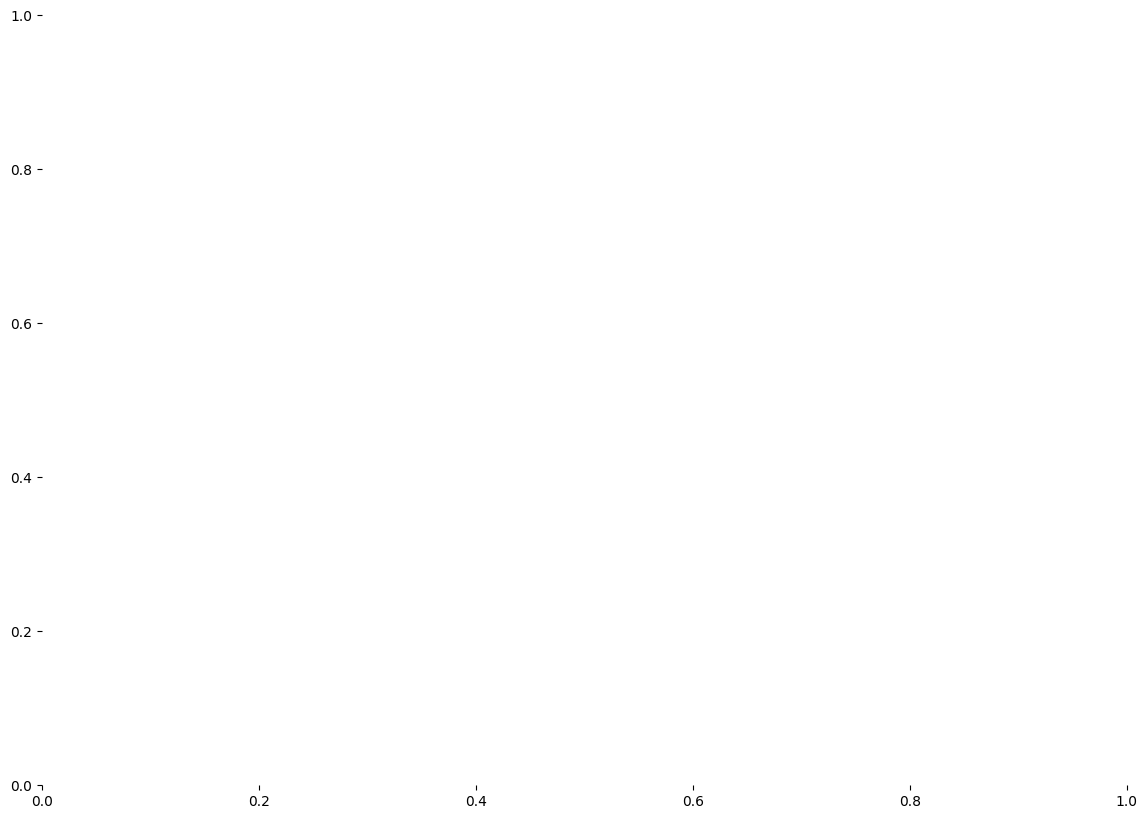

In [27]:
# Set the index to ['date', 'place']
df.set_index(['date', 'place'], inplace=True)

# Unstack the DataFrame to create a multi-index DataFrame suitable for heatmap
df_unstacked = df.unstack(level=0)

# Create a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_unstacked, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Restaurant Availability Heatmap')
plt.xlabel('Time Slot and Date')
plt.ylabel('Restaurant')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('restaurant_availability_heatmap_multiple_dates.png')
plt.show()

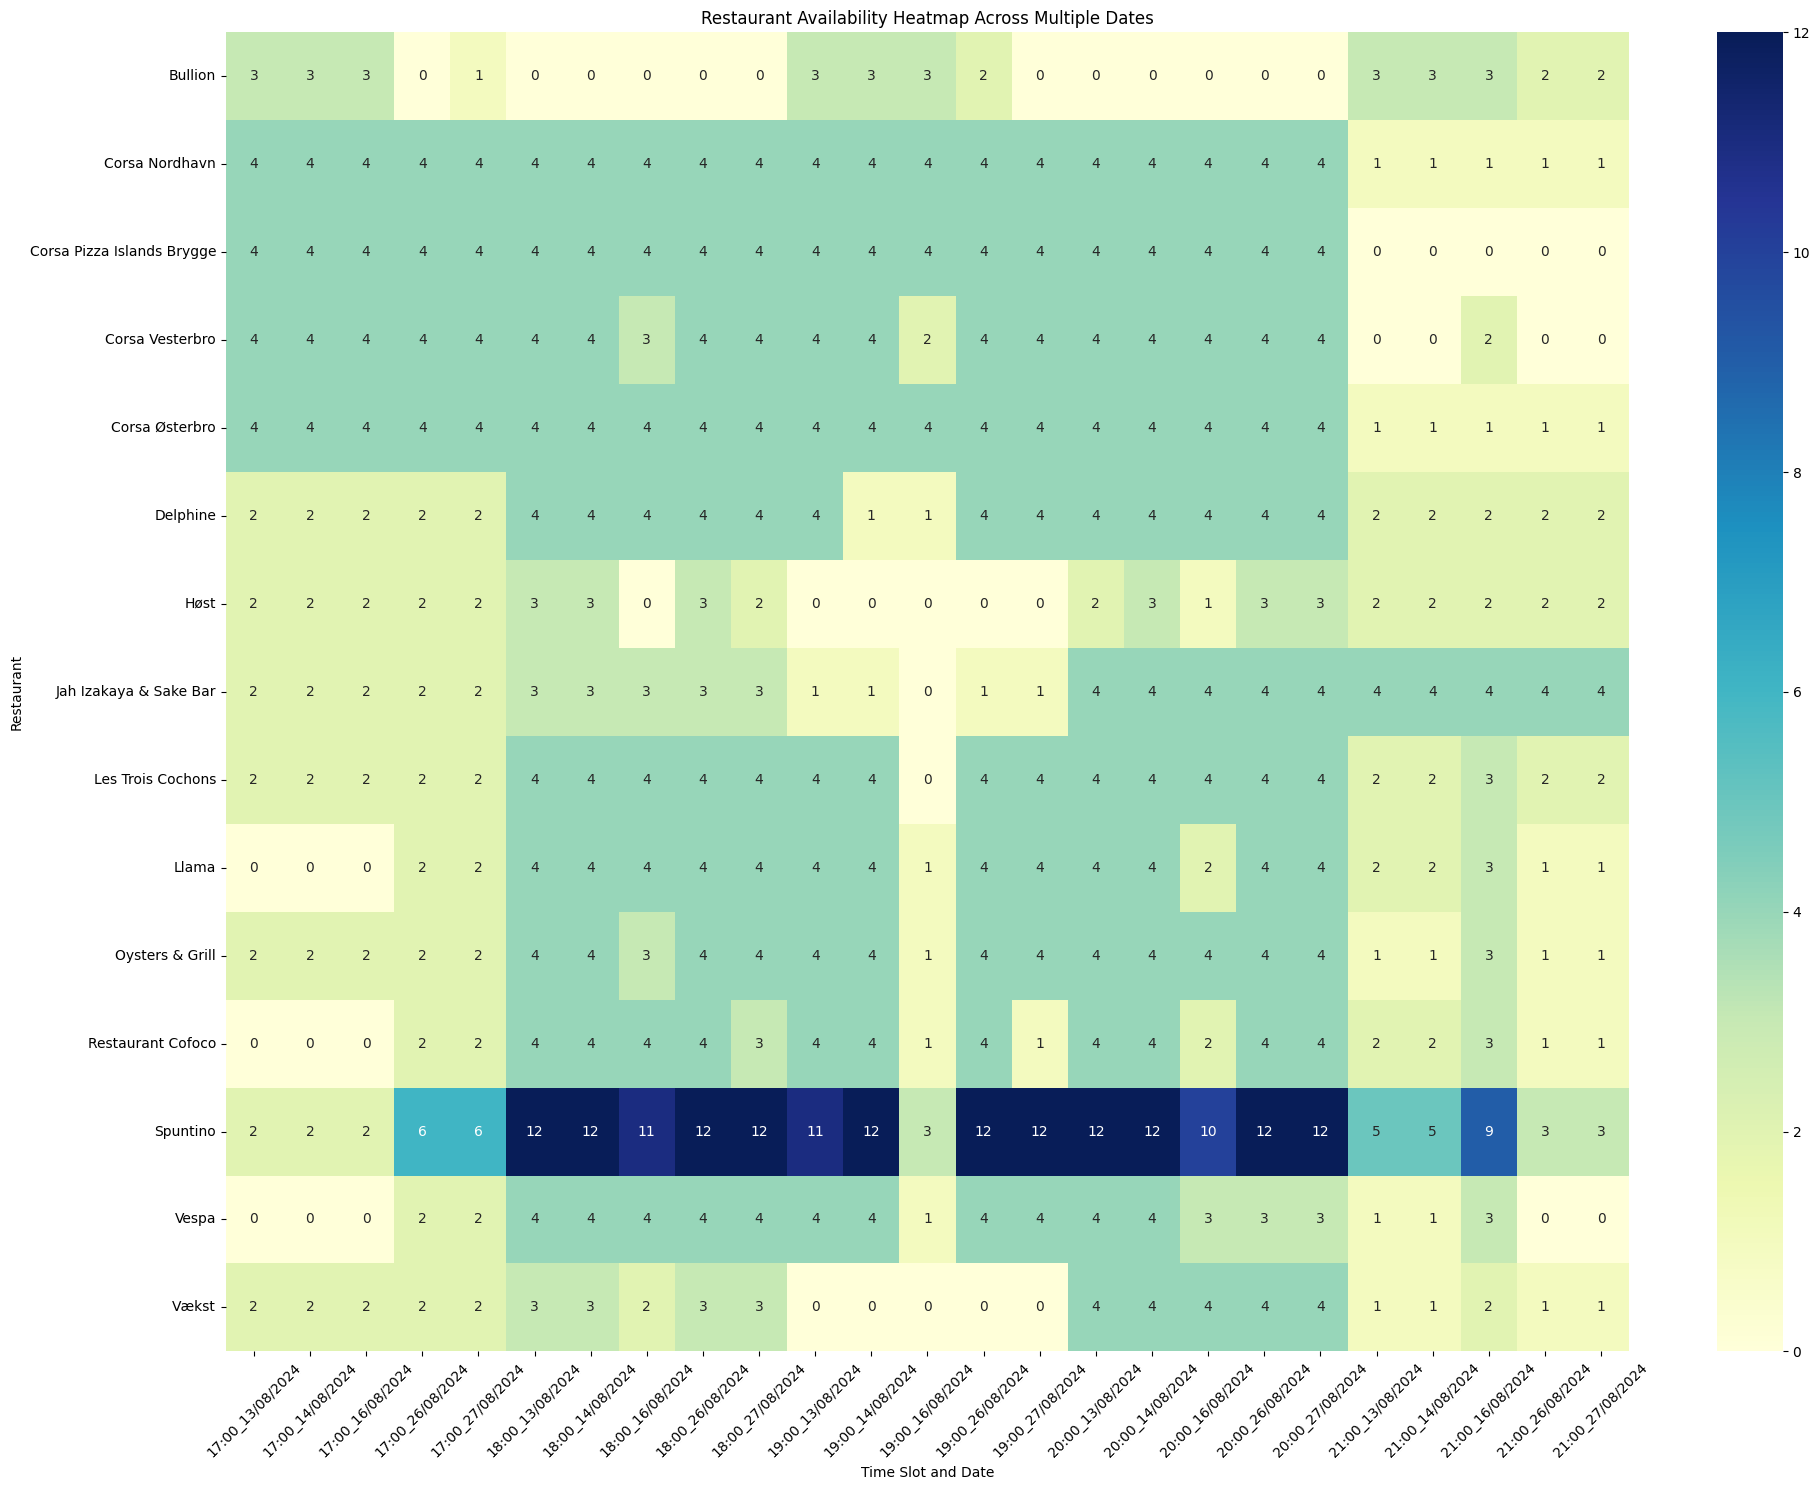

In [22]:
# Pivot the DataFrame to get the desired format for the heatmap
df_pivot = df.pivot_table(index=['place'], columns=['date'], values=['17:00', '18:00', '19:00', '20:00', '21:00'])

# Create a multi-index DataFrame for the heatmap
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
df_pivot = df_pivot.reset_index()

# Plotting the heatmap
fig, axes = plt.subplots(nrows=len(df['date'].unique()), ncols=1, figsize=(15, 20), sharex=True)

for i, date in enumerate(df['date'].unique()):
    df_date = df[df['date'] == date]
    df_date_pivot = df_date.pivot(index='place', columns='date', values=['17:00', '18:00', '19:00', '20:00', '21:00'])
    df_date_pivot.columns = df_date_pivot.columns.droplevel(1)
    
    sns.heatmap(df_date_pivot, annot=True, cmap='YlGnBu', ax=axes[i], cbar=i == 0)
    axes[i].set_title(f'Availability on {date}')
    axes[i].set_xlabel('Time Slot')
    axes[i].set_ylabel('Restaurant')

plt.tight_layout()
plt.savefig('restaurant_availability_heatmap_multiple_dates.png')
plt.show()
